### Week 4 notebook

Each week, you will apply the concepts of that week to your Integrated Capstone Project’s dataset. In preparation for Milestone One, create a Jupyter Notebook (similar to in Module B, semester two) that illustrates these lessons. There are no specific questions to answer in your Jupyter Notebook files in this course; your general goal is to analyze your data using the methods you have learned about in this course and in this program and draw interesting conclusions. 

For Week 4, include concepts such as logistic regression and feature scaling. This homework should be submitted for peer review in the assignment titled 4.3 Peer Review: Week 4 Jupyter Notebook. Complete and submit your Jupyter Notebook homework by 11:59pm ET on Sunday. 

In Week 7, you will compile your findings from your Jupyter Notebook homework into your Milestone One assignment for grading. For full instructions and the rubric for Milestone One, refer to the following link. 

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# Import feature engineering and selection libraries
from sklearn.linear_model import LogisticRegression

# data preprocesing and scoring
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

random_state = 0

In [2]:
def encoding(df_or_series, target=None, cat_cols: list = None, one_hot: bool = False):
    """
    Encodes categorical columns in a DataFrame or a single pandas Series.

    Args:
        df_or_series: DataFrame or Series to encode.
        target: Column name (or iterable of names) to leave untouched when encoding a DataFrame.
        cat_cols: List of columns to encode (only used if input is DataFrame).
        one_hot: If True, use one-hot encoding for DataFrame input.

    Returns:
        If input is DataFrame: encoded DataFrame (and optionally mappings for label encoding).
        If input is Series: encoded Series.
    """
    # Normalize target parameter into a set for quick exclusion checks
    if target is None:
        target_cols = set()
    elif isinstance(target, (list, tuple, set)):
        target_cols = set(target)
    else:
        target_cols = {target}

    if isinstance(df_or_series, pd.Series):
        uniques = df_or_series.dropna().unique().tolist()
        mapping = {cat: code for code, cat in enumerate(uniques)}
        encoded = df_or_series.map(mapping).astype("int64")
        return encoded

    elif isinstance(df_or_series, pd.DataFrame):
        df_encoded = df_or_series.copy()

        if one_hot:
            if cat_cols is None:
                cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
            cat_cols = [c for c in cat_cols if c not in target_cols]
            return pd.get_dummies(df_encoded, columns=cat_cols, drop_first=True)

        if cat_cols is None:
            cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
        cat_cols = [c for c in cat_cols if c not in target_cols]

        mappings = {}
        for col in cat_cols:
            uniques = df_encoded[col].dropna().unique().tolist()
            mapping = {cat: code for code, cat in enumerate(uniques)}
            mappings[col] = mapping
            df_encoded[col] = df_encoded[col].map(mapping).astype("int64")

        return df_encoded

    else:
        raise ValueError("Input must be a pandas DataFrame or Series.")

In [3]:
# Create a function to load and split data
def split_data(df: pd.DataFrame, target=None, test_size=0.2, random_state=random_state, choice='norm'):

    # Feature and target
    X = df.drop(columns=target)
    y = df[target]

    # Train and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

    y_train = np.asarray(y_train).ravel()
    y_test = np.asarray(y_test).ravel()
    
    if choice == 'reg':
        # Regularize the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert scaled features back to DataFrames
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

    else:
        # Bormalize the features
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert scaled features back to DataFrames
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test, df

### Model Functions

In [4]:
results_columns = [
    "run_name",
    "mode",
    "class_weight",
    "best_threshold",
    "accuracy",
    "f1",
    "precision",
    "recall"
]

results_df = pd.DataFrame(columns=results_columns)

def log_regression(X_train, y_train, X_test, y_test, type='class', class_weight='balanced', title=None):
    global results_df

    model = LogisticRegression(random_state=random_state, max_iter=1000, class_weight=class_weight)
    model.fit(X_train, y_train)

    if title is None:
        raise ValueError("Input a title for this run")

    y_proba = model.predict_proba(X_test)[:, 1]

    thresholds = np.linspace(0, 1, 101)
    f1_scores = []
    for thresh in thresholds:
        y_pred_thresh = (y_proba >= thresh).astype(int)
        f1_scores.append(f1_score(y_test, y_pred_thresh, zero_division=0))

    best_thresh = float(thresholds[int(np.argmax(f1_scores))])
    y_pred = (y_proba >= best_thresh).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    score = accuracy

    results_row = {
        "run_name": title,
        "mode": type,
        "class_weight": class_weight,
        "best_threshold": best_thresh,
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }
    results_df = pd.concat([results_df, pd.DataFrame([results_row])], ignore_index=True)

    return model, y_pred, score

## Load Data

In [5]:
df_ins = pd.read_csv(r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\data\insurance_claims_cleaned.csv')
df_car = pd.read_csv(r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\data\carclaims_cleaned.csv')

In [6]:
# Encode the datasets
df_ins_encoded = encoding(df_ins, one_hot=False)
df_ins_oh = encoding(df_ins, one_hot=True)

df_car_encoded = encoding(df_car, one_hot=False)
df_car_oh = encoding(df_car, one_hot=True)

In [7]:
# Regularized data
X_train_car_reg, X_test_car_reg, y_train_car_reg, y_test_car_reg, df_car_reg = split_data(df_car_encoded, target='FraudFound', choice='reg')
X_train_ins_reg, X_test_ins_reg, y_train_ins_reg, y_test_ins_reg, df_ins_reg = split_data(df_ins_encoded, target='fraud_reported', choice='reg')

# Normalized data
X_train_car_norm, X_test_car_norm, y_train_car_norm, y_test_car_norm, df_car_norm = split_data(df_car_encoded, target='FraudFound', choice='norm')
X_train_ins_norm, X_test_ins_norm, y_train_ins_norm, y_test_ins_norm, df_ins_norm = split_data(df_ins_encoded, target='fraud_reported', choice='norm')

# Regularized One-hot data
X_train_car_oh_reg, X_test_car_oh_reg, y_train_car_oh_reg, y_test_car_oh_reg, df_car_oh_reg = split_data(df_car_oh, target='FraudFound', choice='reg')
X_train_ins_oh_reg, X_test_ins_oh_reg, y_train_ins_oh_reg, y_test_ins_oh_reg, df_ins_oh_reg = split_data(df_ins_oh, target='fraud_reported', choice='reg')

# Normalized One-hot data
X_train_car_oh_norm, X_test_car_oh_norm, y_train_car_oh_norm, y_test_car_oh_norm, df_car_oh_norm = split_data(df_car_oh, target='FraudFound', choice='norm')
X_train_ins_oh_norm, X_test_ins_oh_norm, y_train_ins_oh_norm, y_test_ins_oh_norm, df_ins_oh_norm = split_data(df_ins_oh, target='fraud_reported', choice='norm')

C:\Users\JT von Seggern\AppData\Local\Temp\ipykernel_28980\2275669046.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([results_row])], ignore_index=True)


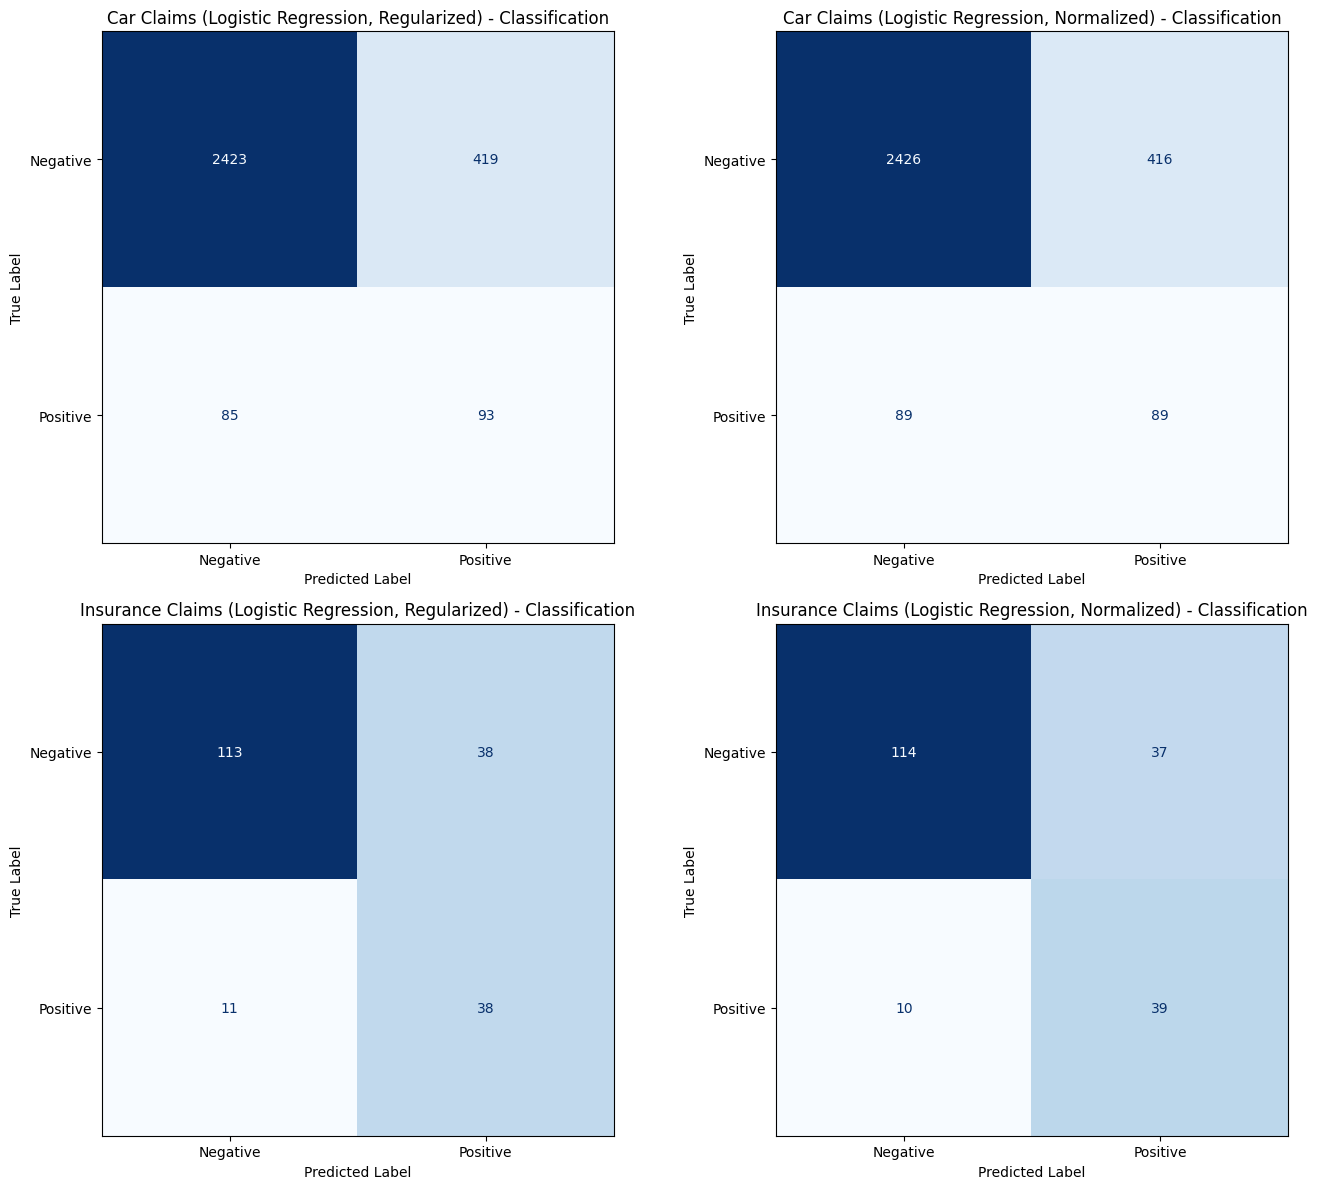

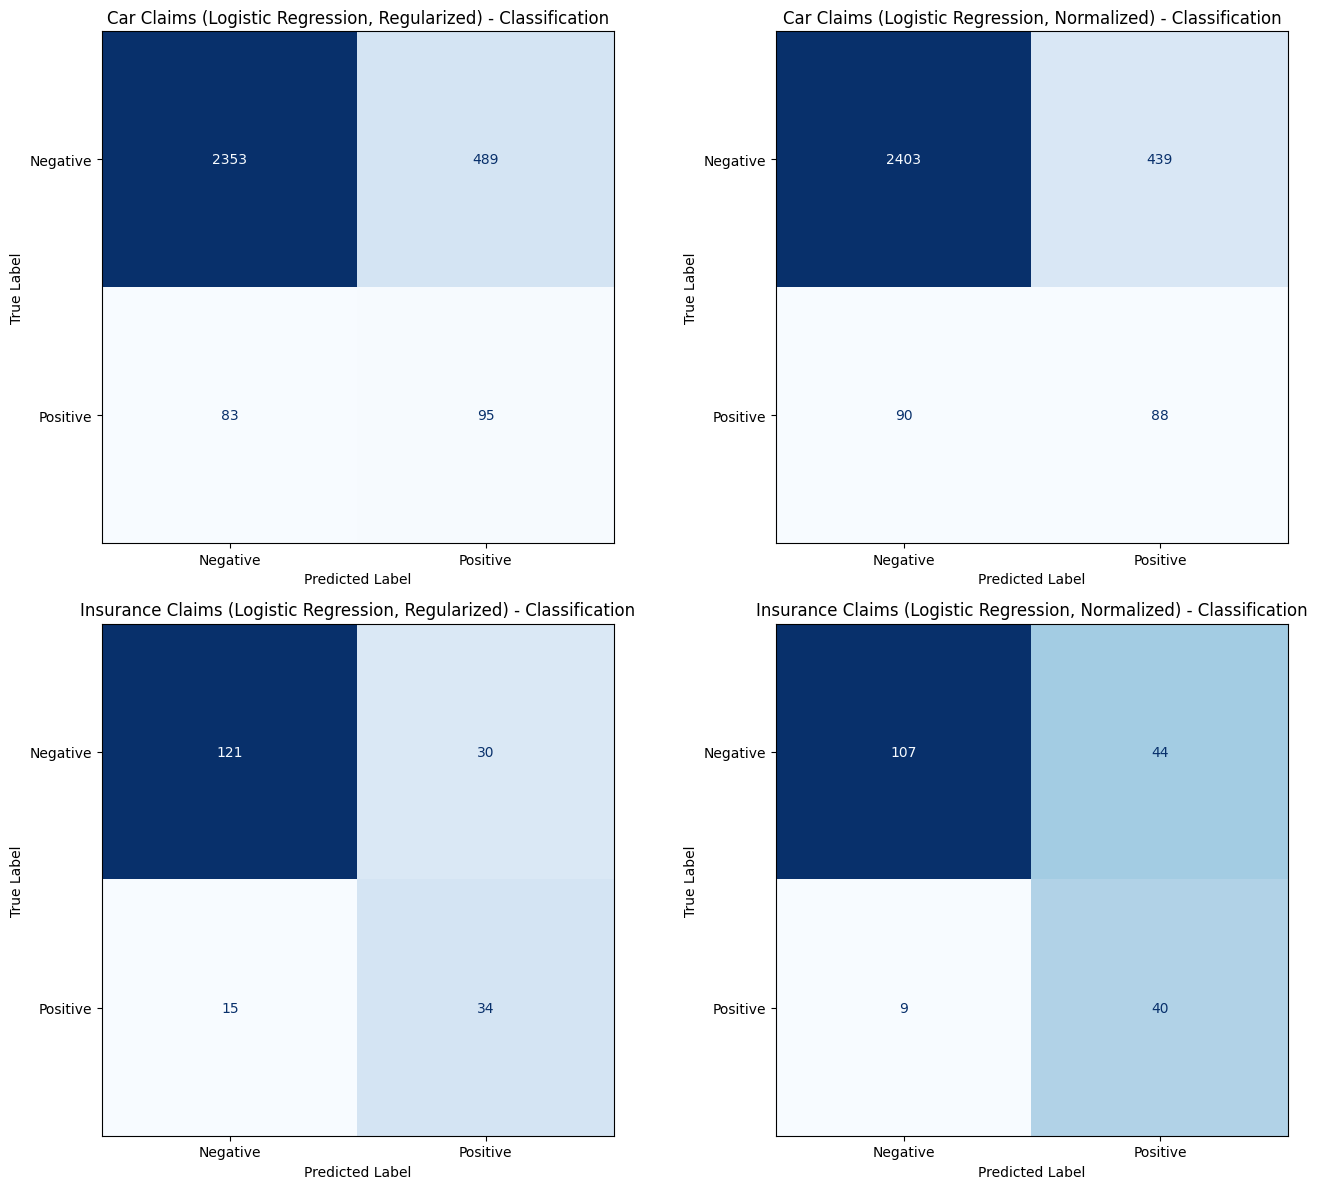

In [8]:
weights = [None, 'balanced']
for i,v in enumerate(weights):    
    # Logistic Regression (Regularized vs Normalized)
    model_car_log_reg_class, y_pred_car_log_reg_class, car_log_rmse_reg_class = log_regression(
        X_train_car_reg, y_train_car_reg, X_test_car_reg, y_test_car_reg,
        type='class',
        title=f'Car Claims | Logistic | StandardScaled | Class Weight={v}',
        class_weight=v
    )
    model_ins_log_reg_class, y_pred_ins_log_reg_class, ins_log_rmse_reg_class = log_regression(
        X_train_ins_reg, y_train_ins_reg, X_test_ins_reg, y_test_ins_reg,
        type='class',
        title=f'Insurance Claims | Logistic | StandardScaled | Class Weight={v}',
        class_weight=v
    )

    model_car_log_norm_class, y_pred_car_log_norm_class, car_log_rmse_norm_class = log_regression(
        X_train_car_norm, y_train_car_norm, X_test_car_norm, y_test_car_norm,
        type='class',
        title=f'Car Claims | Logistic | MinMaxScaled | Class Weight={v}',
        class_weight=v
    )
    model_ins_log_norm_class, y_pred_ins_log_norm_class, ins_log_rmse_norm_class = log_regression(
        X_train_ins_norm, y_train_ins_norm, X_test_ins_norm, y_test_ins_norm,
        type='class',
        title=f'Insurance Claims | Logistic | MinMaxScaled | Class Weight={v}',
        class_weight=v
    )

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Regularized - classification
    cm_car_log_reg = confusion_matrix(y_test_car_reg, y_pred_car_log_reg_class)
    disp_car_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_car_log_reg, display_labels=['Negative', 'Positive'])
    disp_car_log_reg.plot(ax=axes[0][0], colorbar=False, cmap=plt.cm.Blues)
    axes[0][0].set_title("Car Claims (Logistic Regression, Regularized) - Classification")
    axes[0][0].set_xlabel("Predicted Label")
    axes[0][0].set_ylabel("True Label")

    # Normalized - classification
    cm_car_log_norm = confusion_matrix(y_test_car_norm, y_pred_car_log_norm_class)
    disp_car_log_norm = ConfusionMatrixDisplay(confusion_matrix=cm_car_log_norm, display_labels=['Negative', 'Positive'])
    disp_car_log_norm.plot(ax=axes[0][1], colorbar=False, cmap=plt.cm.Blues)
    axes[0][1].set_title("Car Claims (Logistic Regression, Normalized) - Classification")
    axes[0][1].set_xlabel("Predicted Label")
    axes[0][1].set_ylabel("True Label")

    # Regularized - classification
    cm_ins_log_reg = confusion_matrix(y_test_ins_reg, y_pred_ins_log_reg_class)
    disp_ins_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_ins_log_reg, display_labels=['Negative', 'Positive'])
    disp_ins_log_reg.plot(ax=axes[1][0], colorbar=False, cmap=plt.cm.Blues)
    axes[1][0].set_title("Insurance Claims (Logistic Regression, Regularized) - Classification")
    axes[1][0].set_xlabel("Predicted Label")
    axes[1][0].set_ylabel("True Label")

    # Normalized - classification
    cm_ins_log_norm = confusion_matrix(y_test_ins_norm, y_pred_ins_log_norm_class)
    disp_ins_log_norm = ConfusionMatrixDisplay(confusion_matrix=cm_ins_log_norm, display_labels=['Negative', 'Positive'])
    disp_ins_log_norm.plot(ax=axes[1][1], colorbar=False, cmap=plt.cm.Blues)
    axes[1][1].set_title("Insurance Claims (Logistic Regression, Normalized) - Classification")
    axes[1][1].set_xlabel("Predicted Label")
    axes[1][1].set_ylabel("True Label")

    plt.tight_layout()
    plt.show()
    None

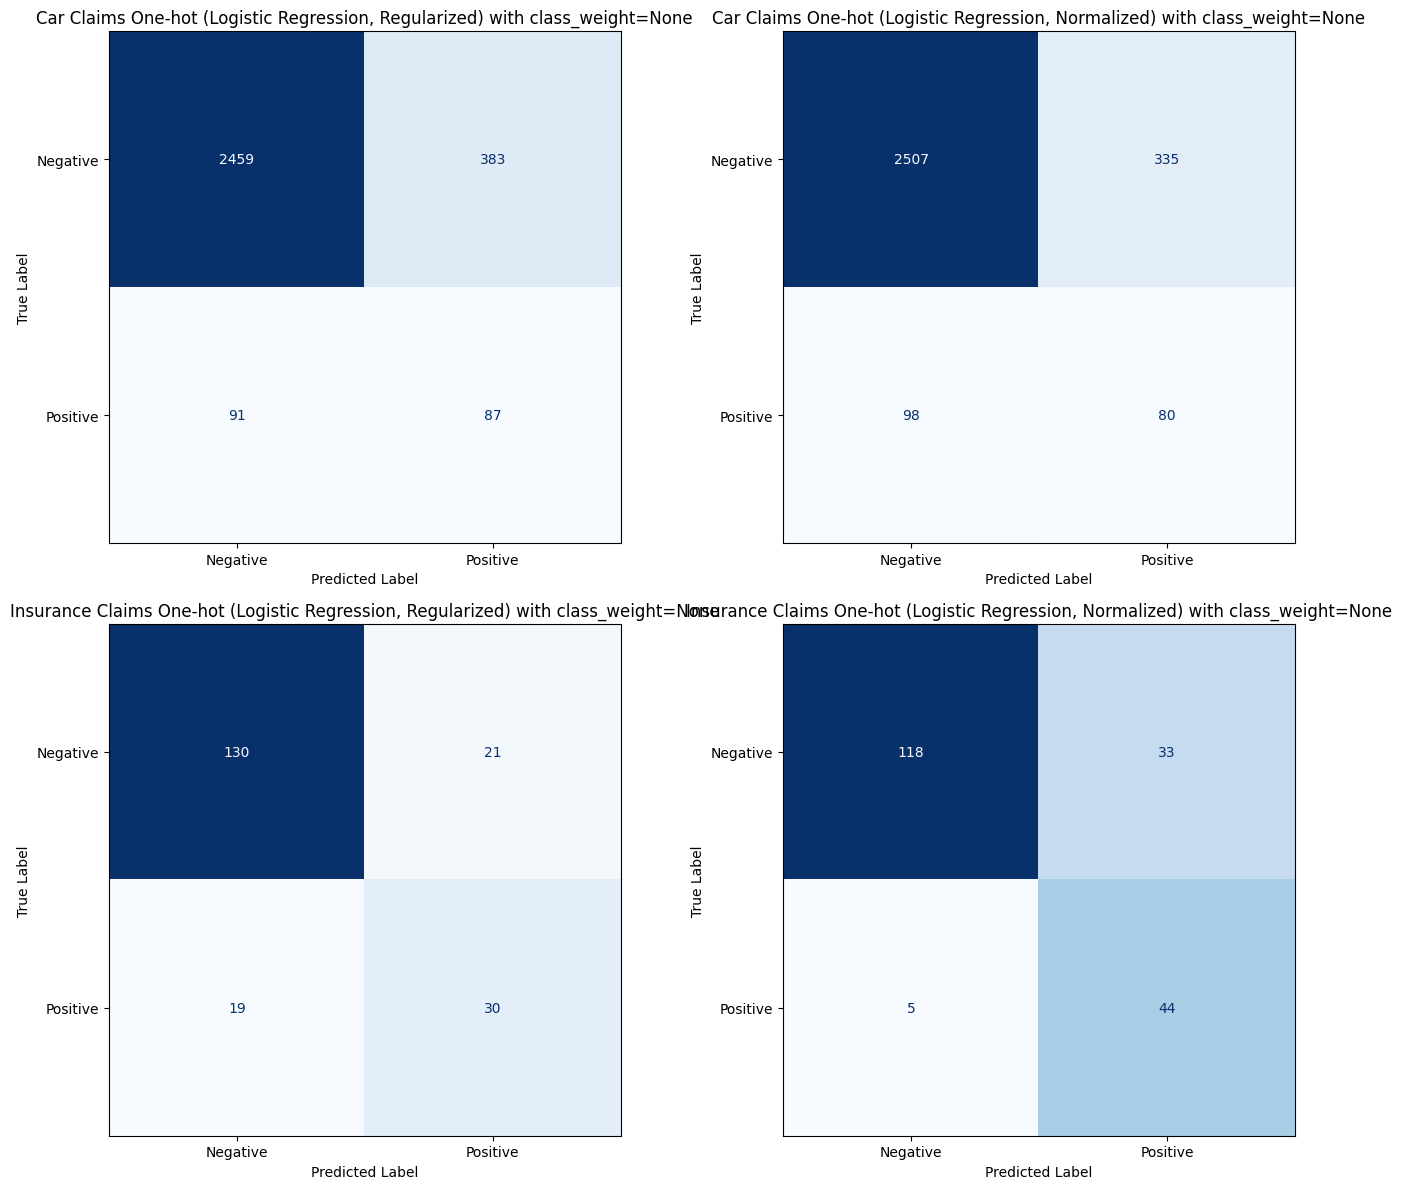

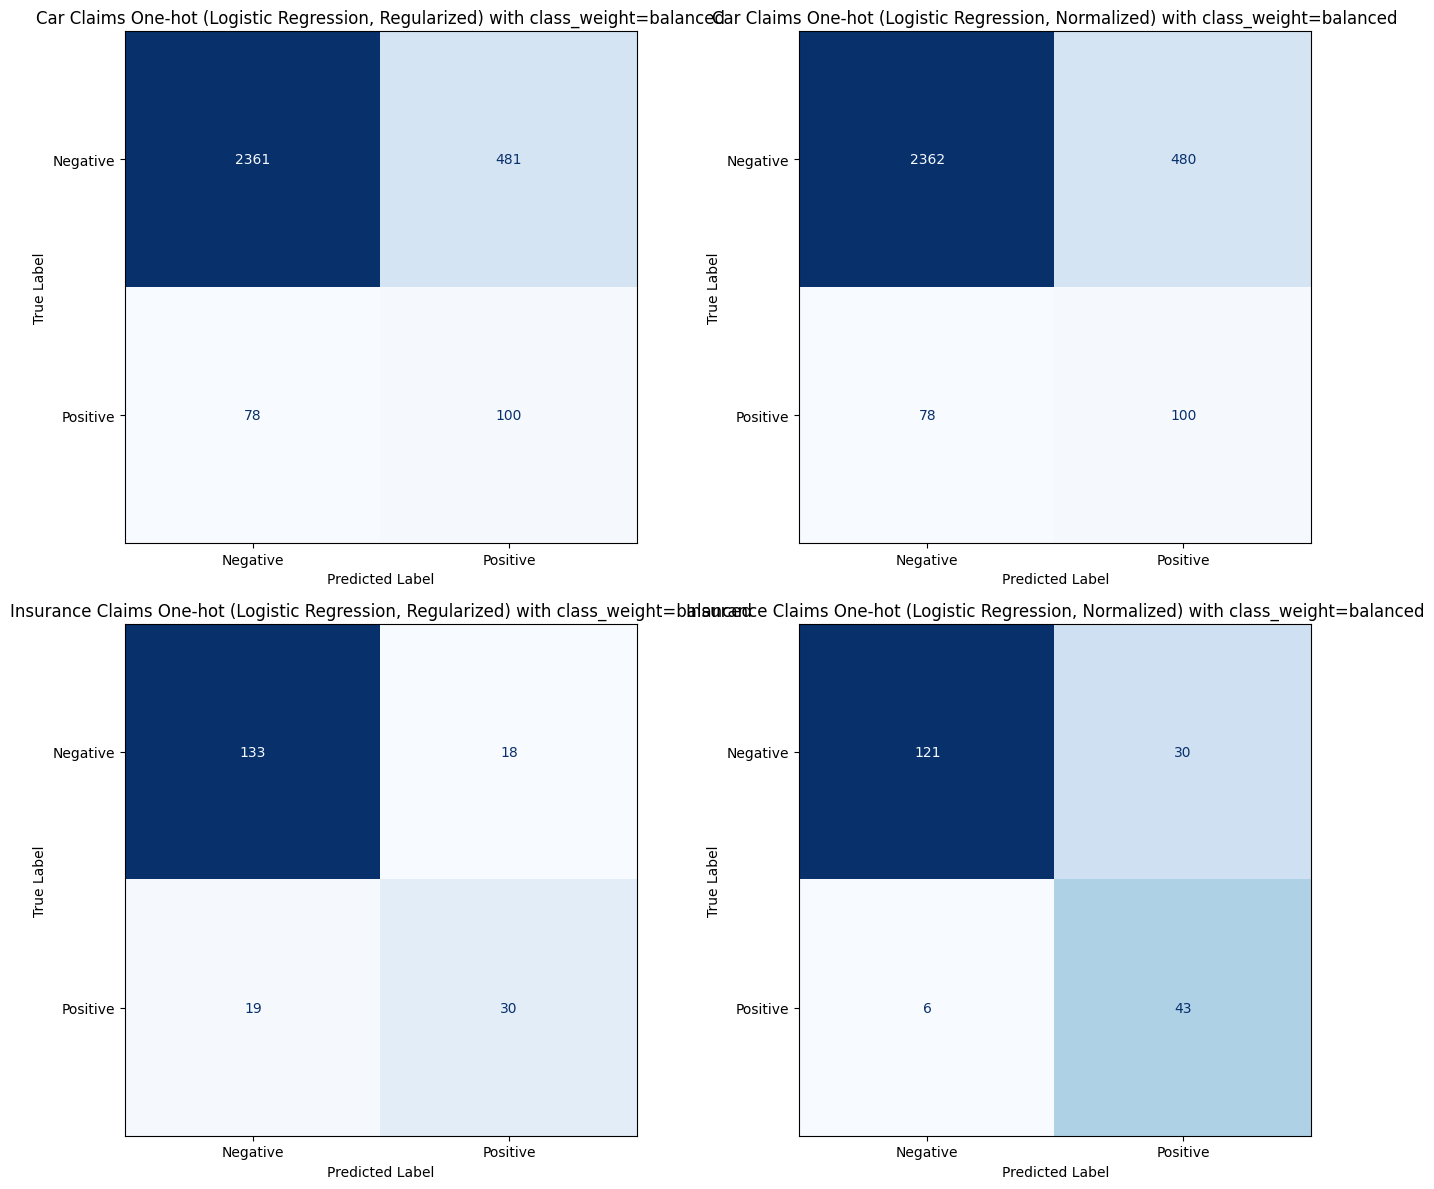

In [9]:
for i, v in enumerate(weights):
    # Logistic Regression One-hot (Regularized vs Normalized)
    model_car_log_reg_class, y_pred_car_log_reg_class, car_log_rmse_reg_class = log_regression(
        X_train_car_oh_reg, y_train_car_oh_reg, X_test_car_oh_reg, y_test_car_oh_reg,
        type = 'class',
        title = f"Car Claims | Logistic | StandardScaled | One-hot | Class Weight={v}",
        class_weight=v)
    model_ins_log_reg_class, y_pred_ins_log_reg_class, ins_log_rmse_reg_class = log_regression(
        X_train_ins_oh_reg, y_train_ins_oh_reg, X_test_ins_oh_reg, y_test_ins_oh_reg,
        type = 'class',
        title = f"Insurance Claims | Logistic | StandardScaled | One-hot | Class Weight={v}",
        class_weight=v)

    model_car_log_norm_class, y_pred_car_log_norm_class, car_log_rmse_norm_class = log_regression(
        X_train_car_oh_norm, y_train_car_oh_norm, X_test_car_oh_norm, y_test_car_oh_norm,
        type = 'class',
        title = f"Car Claims | Logistic | MinMaxScaled | One-hot | Class Weight={v}",
        class_weight=v)
    model_ins_log_norm_class, y_pred_ins_log_norm_class, ins_log_rmse_norm_class = log_regression(
        X_train_ins_oh_norm, y_train_ins_oh_norm, X_test_ins_oh_norm, y_test_ins_oh_norm,
        type = 'class',
        title = f"Insurance Claims | Logistic | MinMaxScaled | One-hot | Class Weight={v}",
        class_weight=v)

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Regularized - classification
    cm_car_oh_log_reg = confusion_matrix(y_test_car_oh_reg, y_pred_car_log_reg_class)
    disp_car_oh_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_car_oh_log_reg, display_labels=['Negative', 'Positive'])
    disp_car_oh_log_reg.plot(ax=axes[0][0], colorbar=False, cmap=plt.cm.Blues)
    axes[0][0].set_title(f"Car Claims One-hot (Logistic Regression, Regularized) with class_weight={v}")
    axes[0][0].set_xlabel("Predicted Label")
    axes[0][0].set_ylabel("True Label")

    # Normalized - classification
    cm_car_oh_log_norm = confusion_matrix(y_test_car_oh_norm, y_pred_car_log_norm_class)
    disp_car_oh_log_norm = ConfusionMatrixDisplay(confusion_matrix=cm_car_oh_log_norm, display_labels=['Negative', 'Positive'])
    disp_car_oh_log_norm.plot(ax=axes[0][1], colorbar=False, cmap=plt.cm.Blues)
    axes[0][1].set_title(f"Car Claims One-hot (Logistic Regression, Normalized) with class_weight={v}")
    axes[0][1].set_xlabel("Predicted Label")
    axes[0][1].set_ylabel("True Label")

    # Regularized - regression
    cm_ins_oh_log_reg = confusion_matrix(y_test_ins_oh_reg, y_pred_ins_log_reg_class)
    disp_ins_oh_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_ins_oh_log_reg, display_labels=['Negative', 'Positive'])
    disp_ins_oh_log_reg.plot(ax=axes[1][0], colorbar=False, cmap=plt.cm.Blues)
    axes[1][0].set_title(f"Insurance Claims One-hot (Logistic Regression, Regularized) with class_weight={v}")
    axes[1][0].set_xlabel("Predicted Label")
    axes[1][0].set_ylabel("True Label")

    # Normalized - regression
    cm_ins_oh_log_norm = confusion_matrix(y_test_ins_oh_norm, y_pred_ins_log_norm_class)
    disp_ins_oh_log_norm = ConfusionMatrixDisplay(confusion_matrix=cm_ins_oh_log_norm, display_labels=['Negative', 'Positive'])
    disp_ins_oh_log_norm.plot(ax=axes[1][1], colorbar=False, cmap=plt.cm.Blues)
    axes[1][1].set_title(f"Insurance Claims One-hot (Logistic Regression, Normalized) with class_weight={v}")
    axes[1][1].set_xlabel("Predicted Label")
    axes[1][1].set_ylabel("True Label")

    plt.tight_layout()
    plt.show()
    None

In [10]:
# Print the results for Car Claims
results_df[results_df['run_name'].str.contains('Car Claims')].sort_values('recall', ascending=False)

,run_name,mode,class_weight,best_threshold,accuracy,f1,precision,recall
12,Car Claims | Logistic | StandardScaled | One-h...,class,balanced,0.69,0.814901,0.263505,0.172117,0.561798
14,Car Claims | Logistic | MinMaxScaled | One-hot...,class,balanced,0.69,0.815232,0.263852,0.172414,0.561798
4,Car Claims | Logistic | StandardScaled | Class...,class,balanced,0.68,0.810596,0.249344,0.162671,0.533708
0,Car Claims | Logistic | StandardScaled | Class...,class,None,0.12,0.833113,0.269565,0.181641,0.522472
2,Car Claims | Logistic | MinMaxScaled | Class W...,class,None,0.12,0.832781,0.260615,0.176238,0.500000
6,Car Claims | Logistic | MinMaxScaled | Class W...,class,balanced,0.70,0.824834,0.249645,0.166983,0.494382
8,Car Claims | Logistic | StandardScaled | One-h...,class,None,0.13,0.843046,0.268519,0.185106,0.488764
10,Car Claims | Logistic | MinMaxScaled | One-hot...,class,None,0.14,0.856623,0.269815,0.192771,0.449438


In [11]:
# Print the results for Insurance Claims
results_df[results_df['run_name'].str.contains('Insurance Claims')].sort_values('recall', ascending=False)

,run_name,mode,class_weight,best_threshold,accuracy,f1,precision,recall
11,Insurance Claims | Logistic | MinMaxScaled | O...,class,None,0.22,0.810,0.698413,0.571429,0.897959
15,Insurance Claims | Logistic | MinMaxScaled | O...,class,balanced,0.44,0.820,0.704918,0.589041,0.877551
7,Insurance Claims | Logistic | MinMaxScaled | C...,class,balanced,0.52,0.735,0.601504,0.476190,0.816327
3,Insurance Claims | Logistic | MinMaxScaled | C...,class,None,0.30,0.765,0.624000,0.513158,0.795918
1,Insurance Claims | Logistic | StandardScaled |...,class,None,0.29,0.755,0.608000,0.500000,0.775510
5,Insurance Claims | Logistic | StandardScaled |...,class,balanced,0.60,0.775,0.601770,0.531250,0.693878
9,Insurance Claims | Logistic | StandardScaled |...,class,None,0.59,0.800,0.600000,0.588235,0.612245
13,Insurance Claims | Logistic | StandardScaled |...,class,balanced,0.85,0.815,0.618557,0.625000,0.612245
